# Jijmodelingを用いた数理モデルの構築とOpenJijでの最適化計算
このチュートリアルでは、Jijmodelingを用いて数理モデルを定式化し、得られた数理モデルをQUBOに変換し、OpenJijで解くという流れを説明したいと思います。



まず初めに、必要なパッケージをインストールします。
数理モデルを簡単に構築するためのモジュールであるJijmodelingとJijmodelingで記述された数理モデルをQUBOに変換するためのモジュールであるjijmodeling-transpilerをインストールします。
これらは、`pip`を使ってインストールすることができます。

In [ ]:
!pip install jijmodeling
!pip install jijmodeling-transpiler

In [104]:
import jijmodeling as jm
import numpy as np
import matplotlib.pyplot as plt

# 巡回セールスマン問題
制約条件付き最適化問題の例として巡回セールスマン問題を解いていきたいと思います。
巡回セールスマン問題は、一人のセールスマンが決められた都市を全て一度づつ訪問し、最終的に元の都市に帰ってくる時に、都市を巡回する最短経路を求めろという問題です。

### 制約条件
この問題では、セールスマンは一つの地点に一度しか訪れることができないという位置に関する制約条件と、セールスマンが一人なのである時刻では一つの都市にしか存在しないという時間に関する制約条件が存在します。

$t$番目に都市$i$を訪れるとき$x_{t,i}=1$、それ以外では$x_{t,i}=0$とするバイナリ変数を用いると、上記の二つの制約条件は、


$$\text{位置に関する制約条件 : }\sum_{t=1}^N x_{t,i}=1 \quad \forall i$$

$$\text{時間に関する制約条件 : }\sum_{i=1}^N x_{t,i}=1 \quad \forall t$$

と書くことができます。

### 目的関数
巡回セールスマン問題は、都市を巡回する最短経路を求めろという問題でした。
そこで、地点$i$と$j$の間の距離を$d_{ij}$とすると、時刻$t$で都市$i$を訪れ、時刻$t+1$で都市$j$を訪れた時の移動距離は、

$$d_{ij}x_{t,i}x_{t+1,j}$$

と書くことができます。
これを合計したもの、

$$\sum_{t=1}^N\sum_{i=1}^N \sum_{j=1}^N d_{ij}x_{t,i}x_{t+1,j}$$

が今回最小化したい目的関数である、合計移動距離になります。

これまでのチュートリアルで述べたようにイジング最適化を行うためには、このような制約条件を持つ数理モデルをIsingハミルトニアンやQUBOハミルトニアンに変換する必要があります。
このような作業を手で行うと面倒ですし、実際に構築した数理モデルとQUBOの間にバグが入り込む可能性があります。
そこで、このような作業を全て自動でおこなってくれるのがJijModelingです。
JijModelingを用いることで、上記のように構築した数理モデルをコーディングし、それを自動的にQUBOに変換してくれます。
ここでは、上記で説明した巡回セールスマン問題を例にとって、JijModelingの使い方について説明していきます。

## JijModelingを用いた巡回セールスマン問題の数理モデルの構築
まず初めに、JijModelingを用いて、問題の数式を記述していきます。
JijModelingでは、通常の数理最適化計算用のモデラーとは異なり、問題インスタンスのデータとは独立に数理モデルを構築していきます。
このように数理モデルを構築することで、数理モデルの汎用性が担保でき、かつ、紙の上で数式を書くように直感的に数式を記述することができます。
さらに、JijModelingで記述された数理モデルは、notebook上ではtexで確認することができます。

ここでは、JijModelingを用いた数理モデルの構築についてひとつづつ見ていきたいと思います。

まずは、問題を記述するための変数と定数を表現しましょう。

In [105]:
dist = jm.Placeholder("dist", dim=2)
N = jm.Placeholder("N")
x = jm.Binary("x", shape=(N, N))
i = jm.Element("i", (0,N))
j = jm.Element("j", (0,N))
t = jm.Element("t", (0,N))

ここで、`jm.Placeholder`は定数を表現しており、ここでは距離行列と都市数を表現するのに用いています。
巡回セールスマン問題においては、この距離行列と都市数によってさまざまな問題が表現されることになります。

バイナリ変数を表現するのが、`jm.Binary`です。
ここでは、$N\times N$のバイナリ変数を定義しています。
次に、総和などで添字の範囲を表現するために`jm.Element`を用いて、`i`,`j`,`t`という添字を定義しています。

JijModelingでは、`jm.Problem`インスタンスを作成し、それに目的関数や制約条件を追加していきます。
では次に、定義した変数を用いて目的関数を定義していきます。

In [106]:
problem = jm.Problem("TSP")
obj = jm.Sum([t, i, j], dist[i, j] * x[t, i] * x[(t + 1) % N, j])
problem += obj
problem

総和は`jm.Sum`を用いて表現することができます。
`jm.Sum`の最初の引数は総和をとる添字で、TSPの目的関数では、3つの添字について総和を取るので、それらの添字(`jm.element`)をリストで渡しています。

次に、制約条件を追加していきます。

In [107]:
# 制約条件1 : 位置に関するonehot制約
problem += jm.Constraint(
            "onehot_location",
            x[:, i] == 1,
            forall=[i,],
        )

# 制約条件2 : 時間に関するonehot制約
problem += jm.Constraint(
            "onehot_time",
            x[t, :] == 1,
            forall=[t,],
        )

`jm.Constraint`を用いて制約条件表現することができます。
最初の引数は制約条件の名前、2つ目の引数が制約条件を表現した数式になります。

この制約条件には、オプション引数として、`forall`というものがあります。
これは、数理モデルにおいて、「任意の$i$について」や、「$\forall i$」というように表現されているものをJijmodelingで表現するための引数です。

また、制約条件の中に現れている`x[:,i]`という記法は、`jm.Sum(t,x[t,i])`という書き方の糖衣構文になっています。

最後に、今記述した数理モデルを確認してみましょう。

In [108]:
problem

説明で用いた数理モデルと同じ数式が表示されていることがわかります。

以上で、数理モデルの構築は終わりです。
このようにJijModelingを用いると、手元の数式と見比べながら数理モデルをコーディングしていくことができます。

## 問題データの作成
問題の数理モデルができたので、次に問題に使うデータを作成します。
ここでは、単純な都市数10で、都市間の距離をランダムにした問題を解いていきます。

(0.0, 1.0)

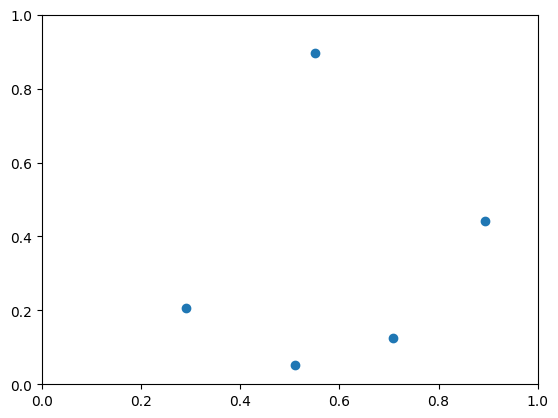

In [109]:
N = 5
np.random.seed(3)

x_pos = np.random.rand(N) 
y_pos = np.random.rand(N) 

plt.plot(x_pos, y_pos, 'o')
plt.xlim(0, 1)
plt.ylim(0, 1)

数理モデルを作る際に用いた`jm.Placeholder`にデータを代入するので、Placeholderの名前をkeyに持つ辞書でデータを渡す必要があります。
今回の問題では、`N`と`dist`に値を渡す必要があります。

In [110]:
XX, XX_T = np.meshgrid(x_pos, x_pos)
YY, YY_T = np.meshgrid(y_pos, y_pos)
distance = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)
instance_data = {
    "N":N,"dist": distance
}
instance_data

{'N': 5,
 'dist': array([[0.        , 0.7866063 , 0.73643374, 0.84577089, 0.56967619],
        [0.7866063 , 0.        , 0.4251585 , 0.21078131, 0.36540009],
        [0.73643374, 0.4251585 , 0.        , 0.26950348, 0.64576184],
        [0.84577089, 0.21078131, 0.26950348, 0.        , 0.54552992],
        [0.56967619, 0.36540009, 0.64576184, 0.54552992, 0.        ]])}

## JijModeling-Transpilerを用いた数理モデルのQUBOへの変換
数理モデルとデータの用意ができたので、次にJijModeling-Transpilerを用いて数理モデルとデータをQUBOに変換します。

まずは、QUBOに変換するための関数である`to_pyqubo`をimportします。

In [26]:
from jijmodeling.transpiler.pyqubo import to_pyqubo

この`to_pyqubo`に作成した数理モデルと問題のデータを与えることでpyquboオブジェクトを作ることができます。
ここでは用いませんでしたが、変数の一部をある値に固定したいという場合には、3番目の変数に固定したい変数と値を辞書として与えることで変数の固定化をすることができます。

In [27]:
model,cache = to_pyqubo(problem,instance_data,{})

得られたpyquboオブジェクトに制約条件の係数の大きさを与え、`to_qubo`を行うことでQUBOを生成することができます。

In [87]:
multipliers = {"onehot_location":1.0,"onehot_time":1.0}
Q,offset = model.compile().to_qubo(feed_dict = multipliers)

これでQUBOを生成することができました。

# OpenJijを用いた最適化の実行
ここでまでQUBOが得られているので、このQUBOを用いてこれまでと同様に最適化計算を行うことができます。

In [88]:
import openjij as oj

In [130]:
sampler = oj.SASampler(num_reads=1)
res = sampler.sample_qubo(Q=Q)

JijModeling-Transpilerの機能を用いれば、最適化によって得られた結果をよりみやすい形に整形してくれます。
そこで、`decode`機能を使ってみましょう。

In [131]:
result = cache.decode(res)
result

SampleSet(record=Record(solution={'x': [(([0, 1, 2, 3, 4], [0, 2, 3, 1, 4]), [1, 1, 1, 1, 1], ())]}, num_occurrences=[1]), evaluation=Evaluation(energy=[-7.848205186671935], objective=[2.151794813328065], constraint_violations={'onehot_location': [0.0], 'onehot_time': [0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))

得られた解は`result.record`の`solution`の中に入っています。
この中に結果は疎行列の形で入っています。
大事なのが最初の二つの要素で、ひとつ目が行列の中のindexそして、二つ目がそのindexにおける値が入っています。
バイナリ変数の場合には、1となった値のみが入っているので、通常、値には1しか入っていません。

In [132]:
sparse_index,value,_ = result.record.solution['x'][0]
sparse_index

([0, 1, 2, 3, 4], [0, 2, 3, 1, 4])

`result.evaluation`の中には、最適化によって得られた評価値として、エネルギーや目的関数、そして、制約条件の破れが入っています。
ここで、制約条件を満たした解が得られたかをチェックしてみます。

In [133]:
result.evaluation.constraint_violations

{'onehot_location': [0.0], 'onehot_time': [0.0]}

制約条件を満たした解が得られているようです。

そこで、この解を可視化してみましょう。
ルートをプロットする場合には、時間に関するindexを用いて、都市のindexをソートしてあげることで、どの順番に都市を回るかという順序を得ることができます。

In [134]:
time_indices, city_indices = zip(*sorted(zip(*sparse_index)))
time_indices, city_indices

((0, 1, 2, 3, 4), (0, 2, 3, 1, 4))

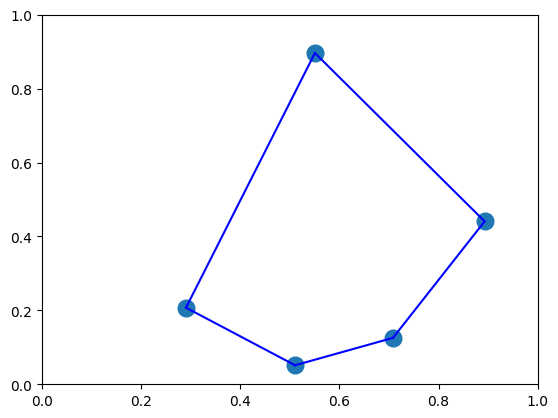

In [135]:
plt.plot(x_pos, y_pos, 'o',markersize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)

for i, city_index in enumerate(city_indices[:-1]):
    next_city_index = city_indices[i+1]
    plt.plot([x_pos[city_index],x_pos[next_city_index ]],[y_pos[city_index],y_pos[next_city_index ]],c = "blue")
    
plt.plot([x_pos[city_indices[-1]],x_pos[city_indices[0]]],[y_pos[city_indices[-1]],y_pos[city_indices[0]]],c = "blue")